M2 Mathématiques pour les Sciences du Vivant 2020/2021
<br/> Alexandre Martin

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Identification de paramètres : 
    <br/>Application à des modèles épidémiologiques</div>



1. [Un premier modèle épidémiologique (1927)](#first)
2. [Modèles à compartiments pour modéliser la propagation du SARS-Cov-2](#second)
3. [Données disponibles pour "caler" les paramètres des modèles](#third)
4. [Identification des paramètres](#fourth)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# <a id="first"></a> 1. Un premier modèle épidémiologique (1927) #

### 1.1) EDO satisfaite par R ###

Il vient :
$$ \frac{d(ln(S_t))}{dt} = \frac{S'_t}{S_t} = -\frac{\beta}{P}I_t = -\frac{\beta}{P\gamma}R'_t $$
d'où l'on tire :
$$ ln(\frac{S_t}{S_0}) = -\frac{\beta}{P\gamma}(R_t - R_0) $$
puis ($R_0 = 0$) :
$$ S_t = S_0exp(-\frac{\beta}{P\gamma}R_t) $$
Enfin comme :
$$ R'_t = \gamma I_t = \gamma(P - S_t - R_t) $$
on en déduit :
$$ R'_t = \gamma (P - S_0exp(-\frac{\beta}{P\gamma}R_t ) - R_t) $$

### 1.2) Implémentation et résolution du modèle SIR ###

Mise en forme des paramètres :

0. Population totale : $P$
1. Taux de contagiosité : $\gamma$
2. Taux d'incidence : $\beta$
3. Nombre de personnes infectées à $t = 0$ : $I_0$
4. Nombre de personnes rétablies ou décédées à $t = 0$ : $R_0$

Les paramètres suivants se déduisent des précédents :

5. Nombre de personnes saines à $t = 0$ : $S_0 = P - I_0 - R_0$
6. Taux de reproduction (**changement de notation**) : $A_0 = \frac{\beta}{\gamma}$

#### Méthodes d'Euler et de Runge-Kutta ####

In [2]:
### Modèle SIR pour le calcul de R

def modele_SIR_R(t, y, p):
    
    # Récupération des paramètres
    P, gamma, beta, I0, R0 = p[0], p[1], p[2], p[3], p[4]
    S0 = P - I0 - R0
    
    # EDO vérifiée par R
    return gamma*(P - S0*np.exp(-beta*y/(gamma*P)) - y)

In [3]:
### Schéma d'Euler

def Euler(f, t0, tf, y0, n, p):
    
    # Initialisation
    y, t = y0, t0
    pas = (tf - t0)/n
    Y, T = np.array([y0]), np.array([t0])
    
    # Itérations
    for k in range(n):
        y, t = y + pas*f(t, y, p), t + pas
        Y = np.append(Y, y)
        T = np.append(T, t)
    
    return T, Y

In [4]:
### Schéma de Runge-Kutta 4

def RK4(f, t0, tf, y0, n, p):
   
    # Initialisation
    y, t = y0, t0
    pas = (tf - t0)/n
    Y, T = np.array([y0]), np.array([t0])

    # Itérations
    for k in range(n):
        p1 = f(t, y, p)
        p2 = f(t + pas/2, y + pas*p1/2, p)
        p3 = f(t + pas/2, y + pas*p2/2, p) 
        p4 = f(t + pas, y + pas*p3, p)
        y, t = y + pas/6 * (p1 + 2*p2 + 2*p3 + p4), t + pas
        Y = np.append(Y, y)
        T = np.append(T, t)
   
    return T, Y

#### Visualisation ####

In [5]:
### Initialisation des paramètres 

# p = [P, gamma, beta, I0, R0]
p = [1000, 0.0625, 0.1625, 1, 0]

# Etude pour A0 < 1 :
# p = [1000, 0.1625, 0.0625, 1, 0]

R0 = p[4]
T = 200
n = 200 # nombre d'itérations (nombre de points = n+1)

In [6]:
### Modélisation

modele = modele_SIR_R

t_Euler, R_Euler = Euler(modele, 0, T, R0, n, p)
t_RK4, R_RK4 = RK4(modele, 0, T, R0, n, p)

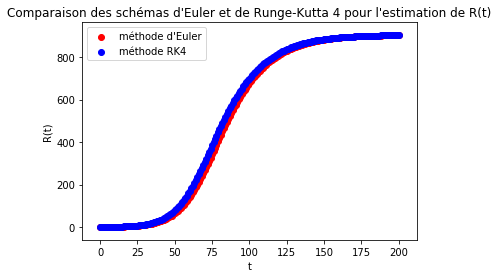

In [7]:
### Schémas d'Euler et RK4 pour R(t)

plt.figure()

plt.scatter(t_Euler, R_Euler, c="red", label="méthode d'Euler")
plt.scatter(t_RK4, R_RK4, c="blue", label="méthode RK4")
plt.title("Comparaison des schémas d'Euler et de Runge-Kutta 4 pour l'estimation de R(t)")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

In [8]:
### Calcul de S(t) 

P, gamma, beta, I0, R0 = p[0], p[1], p[2], p[3], p[4]
S0 = P - I0 - R0

S_Euler = [S0*np.exp(-beta*y/(gamma*P)) for y in R_Euler]
S_RK4 = [S0*np.exp(-beta*y/(gamma*P)) for y in R_RK4]

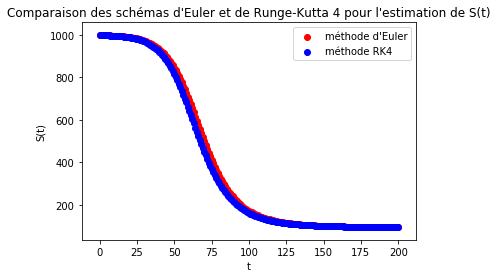

In [9]:
### Schémas d'Euler et RK4 pour S(t)

plt.figure()

plt.scatter(t_Euler, S_Euler, c="red", label="méthode d'Euler")
plt.scatter(t_RK4, S_RK4, c="blue", label="méthode RK4")
plt.title("Comparaison des schémas d'Euler et de Runge-Kutta 4 pour l'estimation de S(t)")
plt.xlabel("t")
plt.ylabel("S(t)")
plt.legend()

plt.show()

In [10]:
### Calcul de I(t)

# On construit I(t) par approximation de R'(t) sous forme d'un taux d'accroissement

pas = T/(n-1)

I_Euler = [I0]
I_RK4 = [I0]

for i in range(1, n+1):
    I_Euler.append((R_Euler[i] - R_Euler[i-1])/(gamma*pas))
    I_RK4.append((R_RK4[i] - R_RK4[i-1])/(gamma*pas))

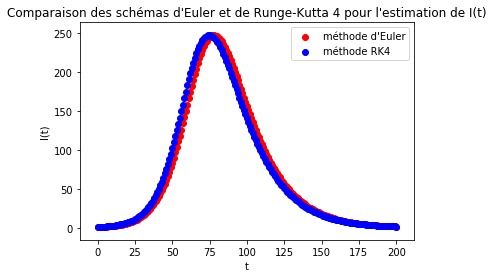

In [11]:
### Schémas d'Euler et RK4 pour I(t)

plt.figure()

plt.scatter(t_Euler, I_Euler, c="red", label="méthode d'Euler")
plt.scatter(t_RK4, I_RK4, c="blue", label="méthode RK4")
plt.title("Comparaison des schémas d'Euler et de Runge-Kutta 4 pour l'estimation de I(t)")
plt.xlabel("t")
plt.ylabel("I(t)")
plt.legend()

plt.show()

In [12]:
### Vérification P = constante
PP = [P for t in t_Euler]

P_Euler = [x+y+z for x, y, z in zip(R_Euler, S_Euler, I_Euler)]
P_RK4 = [x+y+z for x, y, z in zip(R_RK4, S_RK4, I_RK4)]

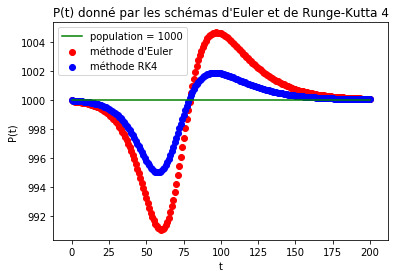

In [13]:
### Schémas d'Euler et RK4 pour P(t)

plt.figure()

plt.scatter(t_Euler, P_Euler, c="red", label="méthode d'Euler")
plt.scatter(t_RK4, P_RK4, c="blue", label="méthode RK4")
plt.plot(t_Euler, PP, c="green", label="population = 1000")
plt.title("P(t) donné par les schémas d'Euler et de Runge-Kutta 4")
plt.xlabel("t")
plt.ylabel("P(t)")
plt.legend()

plt.show()

In [14]:
# Quand n est suffisamment grand, il semble y avoir :
# 1) convergence des deux schémas l'un sur l'autre
# 2) convergence de l'estimation de la population vers P = 1000 pour chaque schéma (la méthode RK4 converge cependant plus vite)

In [15]:
# On remarque bien que lorsque A0 < 1, l'épidémie s'éteint dès les premères itérations

#### Solution de référence ####

In [16]:
### Initialisation des paramètres

# p = [P, gamma, beta, I0, R0]
p = [1000, 0.0625, 0.1625, 1, 0]
R0 = p[4]
T = 200
n = 2**11 # nombre d'itérations (nombre de points = n+1)

In [17]:
### Modélisation : solution de référence

modele = modele_SIR_R

t_ref_Euler, y_ref_Euler = Euler(modele, 0, T, R0, n, p)
t_ref_RK4, y_ref_RK4 = RK4(modele, 0, T, R0, n, p)

In [18]:
### Modélisation : solutions approchées et calcul des erreurs

E_Euler, E_RK4 = [], []

for i in range(3, 11):
    t_Euler, y_Euler = Euler(modele, 0, T, R0, 2**i, p)
    t_RK4, y_RK4 = RK4(modele, 0, T, R0, 2**i, p)
    
    e_Euler = 0
    e_RK4 = 0
    
    for j in range(len(t_Euler) - 1):
        if np.abs(y_Euler[j] - y_ref_Euler[j * 2**(11-i)]) > e_Euler:
            e_Euler = np.abs(y_Euler[j] - y_ref_Euler[j * 2**(11-i)])
        if np.abs(y_RK4[j] - y_ref_RK4[j * 2**(11-i)]) > e_RK4:
            e_RK4 = np.abs(y_RK4[j] - y_ref_RK4[j * 2**(11-i)])
            
    E_Euler.append(e_Euler)
    E_RK4.append(e_RK4)

In [19]:
ln_pas = [np.log(200/2**i) for i in range(3, 11)]
ln_E_Euler = [np.log(e) for e in E_Euler]
ln_E_RK4 = [np.log(e) for e in E_RK4]

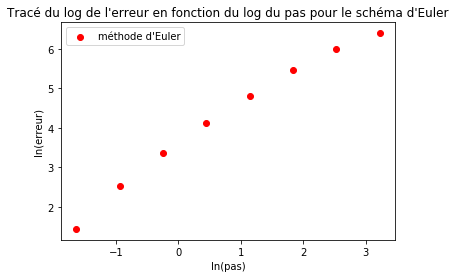

In [20]:
### Tracé du log de l'erreur en fonction du log du pas pour Euler

plt.figure()

plt.scatter(ln_pas, ln_E_Euler, c="red", label="méthode d'Euler")
plt.title("Tracé du log de l'erreur en fonction du log du pas pour le schéma d'Euler")
plt.xlabel("ln(pas)")
plt.ylabel("ln(erreur)")
plt.legend()

plt.show()

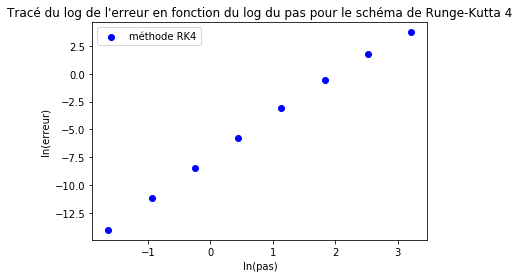

In [21]:
### Tracé du log de l'erreur en fonction du log du pas pour RK4

plt.figure()

plt.scatter(ln_pas, ln_E_RK4, c="blue", label="méthode RK4")
plt.title("Tracé du log de l'erreur en fonction du log du pas pour le schéma de Runge-Kutta 4")
plt.xlabel("ln(pas)")
plt.ylabel("ln(erreur)")
plt.legend()

plt.show()

In [22]:
# On obtient bien un ordre de précision 1 pour Euler, 4 pour Runge-Kutta

### 1.3) Comparaison avec de vraies données ###

In [23]:
### Données de l'épidémie de peste de Bombay (1905 - 1906) pour I(t)

data = np.array([
    [0,8], [1,10], [2,12], [3,16], [4,24], [5,48], [6,51], [7,92], [8,124],
    [9,178], [10,280], [11,387], [12,442], [13,644], [14,779], [15,702],
    [16,695], [17,870], [18,925], [19,802], [20,578], [21,404],
    [22,296], [23,162], [24,106], [25,64], [26,46], [27,35], [28,27],
    [29,28], [30,24]
])

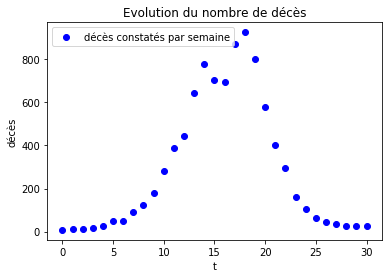

In [24]:
### Tracé des décès

plt.figure()

plt.scatter(data[:,0], data[:,1], c="blue", label="décès constatés par semaine")
plt.title("Evolution du nombre de décès")
plt.xlabel("t")
plt.ylabel("décès")
plt.legend()

plt.show()

In [25]:
### Conversion vers R(t)

proportion_morts = 0.85

data1 = data.copy()

for i in range(len(data1)):
    s = 0
    for j in range(i):
        s += data[j][1]
    data1[i][1] = s/proportion_morts   

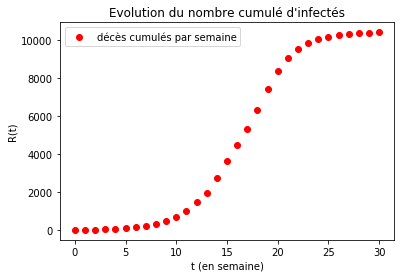

In [26]:
### Tracé de R(t) (semaine)

plt.figure()

plt.scatter(data1[:,0], data1[:,1], c="red", label="décès cumulés par semaine")
plt.title("Evolution du nombre cumulé d'infectés")
plt.xlabel("t (en semaine)")
plt.ylabel("R(t)")
plt.legend()

plt.show()

In [27]:
### Conversion semaines vers jours

data1[:,0] = 7*data1[:,0]

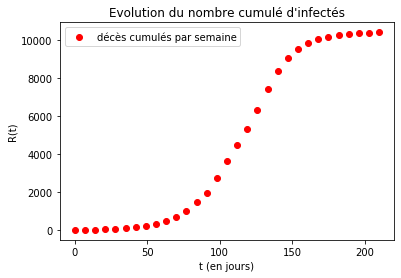

In [28]:
### Tracé de R(t) (jours)

plt.figure()

plt.scatter(data1[:,0], data1[:,1], c="red", label="décès cumulés par semaine")
plt.title("Evolution du nombre cumulé d'infectés")
plt.xlabel("t (en jours)")
plt.ylabel("R(t)")
plt.legend()

plt.show()

In [29]:
### Nombre de points disponibles pour les données réelles

print(len(data1))

31


In [30]:
### Nombre de points utilisés pour simuler les courbes SIR

n = 100*30

In [31]:
### Définition de l'erreur quadratique

def erreur_quad(data_ref, data_sim):
    e = 0
    facteur = int((len(data_sim) - 1)/(len(data_ref) - 1))
    
    for i in range(len(data_ref)):
        e += (data_ref[i] - data_sim[facteur*i])**2
        
    return(np.sqrt(e))

In [32]:
### Données

P = 16961
I0 = 1
R0 = 0

[1216.8629354724287, 0.1346, 0.20850000000000002]


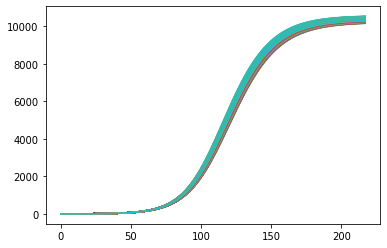

In [33]:
################### PEUT METTRE DU TEMPS A TOURNER ############################################
###############################################################################################

### Recherche des paramètres qui minimisent l'erreur

# Initialisation de l'erreur 
E = erreur_quad(data1[:, 1], np.zeros(31))

# Listes des valeurs des paramètres testées
# Etape 1
# GAMMA = [i*10**-2 for i in range(1,100)]
# BETA = [i*10**-2 for i in range(1,100)]
# best = [2907, 0.13, 0.2]
# Etape 2
# GAMMA = [i*10**-3 for i in range(120, 140)]
# BETA = [i*10**-3 for i in range(190, 210)]
# best = [1217, 0.135, 0.209]
# Etape 3
GAMMA = [i*10**-4 for i in range(1340, 1360)]
BETA = [i*10**-4 for i in range(2080, 2100)]


# Minimisation de l'erreur
for gamma in GAMMA:
    for beta in BETA:
        
        if beta > gamma: # pour gagner du temps de calcul on ne teste que les paramètres donnant A0 > 1
        
            p = [P, gamma, beta, I0, R0]
        
            modele = modele_SIR_R
            t_RK4, y_RK4 = RK4(modele, 0, len(data)*7, R0, n, p) # facteur 7 pour la conversion semaine/jour
        
            plt.plot(t_RK4, y_RK4)
        
            err = erreur_quad(data1[:,1], y_RK4)
        
            if err < E:
                E = err
                beta_sim = beta
                gamma_sim = gamma

print([E, gamma_sim, beta_sim]) 

In [34]:
# On s'arrête à l'étape 3 car le gain sur l'erreur n'est plus significatif 

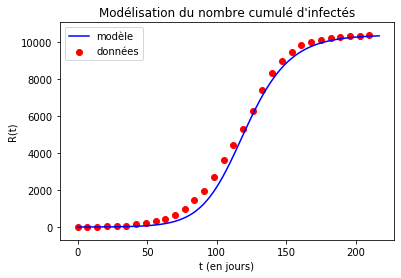

In [35]:
### Comparaison visuelle modèle/données

p = [P, gamma_sim, beta_sim, I0, R0]
modele = modele_SIR_R
schema = RK4(modele, 0, len(data)*7, R0, n, p)

plt.plot(schema[0], schema[1], c="blue", label="modèle")
plt.scatter(data1[:,0], data1[:,1], c="red", label="données")
plt.title("Modélisation du nombre cumulé d'infectés")
plt.xlabel("t (en jours)")
plt.ylabel("R(t)")
plt.legend()

In [36]:
print("gamma estimé = ", gamma_sim)
print("beta estimé = ", round(beta_sim, 4))

gamma estimé =  0.1346
beta estimé =  0.2085


# <a id="second"></a> 2. Modèles à compartiments pour modéliser la propagation du SARS-Cov-2 #

### Modèles SEIR et SEIRD ###

In [37]:
### Modèle SEIR 

def modele_SEIR(t, y, p):
    
    # Récupération des paramètres
    P, gamma, beta, I0, R0, alpha, E0 = p[0], p[1], p[2], p[3], p[4], p[5], p[6]
    S0 = P - I0 - R0 - E0
    
    # Réécriture de y
    S, E, I, R = y[0], y[1], y[2], y[3]
    
    # EDO vérifiée par y
    return np.array([-beta*S*I/P, beta*S*I/P - alpha*E, alpha*E - gamma*I, gamma*I])

In [38]:
### Modèle SEIRD

def modele_SEIRD(t, y, p):
    
    # Récupération des paramètres
    P, gamma, beta, I0, R0, alpha, E0, delta, D0 = p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8]
    S0 = P - I0 - R0 - E0 - D0
    
    # Réécriture de y
    S, E, I, R, D = y[0], y[1], y[2], y[3], y[4]
    
    # EDO vérifiée par y
    return np.array([-beta*S*I/P, beta*S*I/P - alpha*E, alpha*E - gamma*I, (1 - delta)*gamma*I, delta*gamma*I])

### Test et visualisation du modèle SEIR ###

In [39]:
### Initialisation des paramètres 

# p = [P, gamma, beta, I0, R0, alpha, E0]
p = [1000, 0.0625, 0.1625, 1, 0, 0.0625, 0]

y0 = np.array([p[0], p[6], p[3], p[4]])
T = 400
n = 40 # nombre d'itérations (nombre de points = n+1)

In [40]:
### Modélisation

modele = modele_SEIR

t_Euler, y_Euler = Euler(modele, 0, T, y0, n, p)
t_RK4, y_RK4 = RK4(modele, 0, T, y0, n, p)

In [41]:
### Remise en forme des solutions

y_Euler = np.reshape(y_Euler, (n+1, 4))
y_RK4 = np.reshape(y_RK4, (n+1, 4))

In [42]:
### Calcul de la population estimée par les modèles

Pop_Euler = y_Euler[:,0] + y_Euler[:,1] + y_Euler[:,2] + y_Euler[:,3]
Pop_RK4 = y_RK4[:,0] + y_RK4[:,1] + y_RK4[:,2] + y_RK4[:,3]

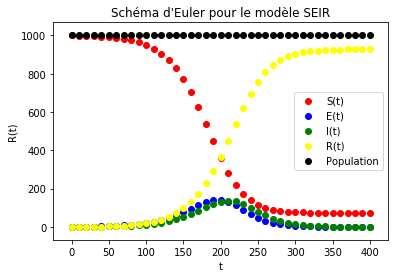

In [43]:
### Schéma d'Euler

plt.figure()

plt.scatter(t_Euler, y_Euler[:,0], c="red", label="S(t)")
plt.scatter(t_Euler, y_Euler[:,1], c="blue", label="E(t)")
plt.scatter(t_Euler, y_Euler[:,2], c="green", label="I(t)")
plt.scatter(t_Euler, y_Euler[:,3], c="yellow", label="R(t)")
plt.scatter(t_Euler, Pop_Euler, c="black", label="Population")
plt.title("Schéma d'Euler pour le modèle SEIR")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

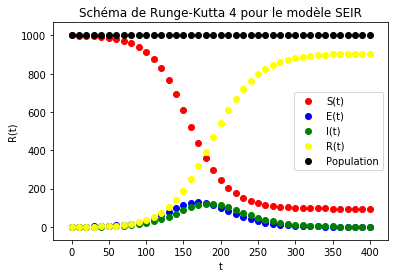

In [44]:
### Schéma de Runge-Kutta 4

plt.figure()

plt.scatter(t_Euler, y_RK4[:,0], c="red", label="S(t)")
plt.scatter(t_Euler, y_RK4[:,1], c="blue", label="E(t)")
plt.scatter(t_Euler, y_RK4[:,2], c="green", label="I(t)")
plt.scatter(t_Euler, y_RK4[:,3], c="yellow", label="R(t)")
plt.scatter(t_Euler, Pop_RK4, c="black", label="Population")
plt.title("Schéma de Runge-Kutta 4 pour le modèle SEIR")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

### Test et visualisation du modèle SEIRD ###

In [45]:
### Initialisation des paramètres 

# p = [P, gamma, beta, I0, R0, alpha, E0, delta, D0]
p = [1000, 0.0625, 0.1625, 1, 0, 0.0625, 0, 0.1, 0]

y0 = np.array([p[0], p[6], p[3], p[4], p[8]])
T = 400
n = 40 # nombre d'itérations (nombre de points = n+1)

In [46]:
### Modélisation

modele = modele_SEIRD

t_Euler, y_Euler = Euler(modele, 0, T, y0, n, p)
t_RK4, y_RK4 = RK4(modele, 0, T, y0, n, p)

In [47]:
### Remise en forme des solutions

y_Euler = np.reshape(y_Euler, (n+1, 5))
y_RK4 = np.reshape(y_RK4, (n+1, 5))

In [48]:
### Calcul de la population estimée par les modèles

Pop_Euler = y_Euler[:,0] + y_Euler[:,1] + y_Euler[:,2] + y_Euler[:,3] + y_Euler[:,4]
Pop_RK4 = y_RK4[:,0] + y_RK4[:,1] + y_RK4[:,2] + y_RK4[:,3] + y_Euler[:,4]

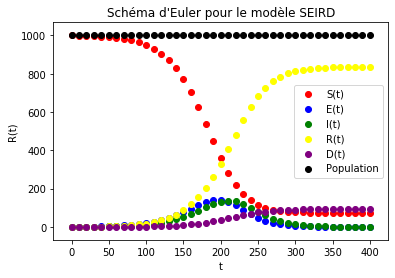

In [49]:
### Schéma d'Euler

plt.figure()

plt.scatter(t_Euler, y_Euler[:,0], c="red", label="S(t)")
plt.scatter(t_Euler, y_Euler[:,1], c="blue", label="E(t)")
plt.scatter(t_Euler, y_Euler[:,2], c="green", label="I(t)")
plt.scatter(t_Euler, y_Euler[:,3], c="yellow", label="R(t)")
plt.scatter(t_Euler, y_Euler[:,4], c="purple", label="D(t)")
plt.scatter(t_Euler, Pop_Euler, c="black", label="Population")
plt.title("Schéma d'Euler pour le modèle SEIRD")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

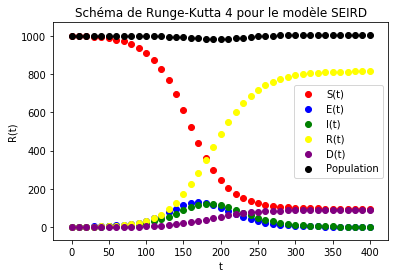

In [50]:
### Schéma de Runge-Kutta 4

plt.figure()

plt.scatter(t_Euler, y_RK4[:,0], c="red", label="S(t)")
plt.scatter(t_Euler, y_RK4[:,1], c="blue", label="E(t)")
plt.scatter(t_Euler, y_RK4[:,2], c="green", label="I(t)")
plt.scatter(t_Euler, y_RK4[:,3], c="yellow", label="R(t)")
plt.scatter(t_Euler, y_RK4[:,4], c="purple", label="D(t)")
plt.scatter(t_Euler, Pop_RK4, c="black", label="Population")
plt.title("Schéma de Runge-Kutta 4 pour le modèle SEIRD")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

# <a id="third"></a> 3. Données disponibles pour "caler" les paramètres des modèles #

### 3.1) Données françaises ###

#### Exploration des données ####

In [51]:
### Récupération des données

data_fra = pd.read_csv("data-fra.csv")

In [52]:
data_fra.head()

,date,total_cas_confirmes,total_deces_hopital,total_deces_ehpad,total_cas_confirmes_ehpad,total_cas_possibles_ehpad,patients_reanimation,patients_hospitalises,total_patients_gueris,nouveaux_patients_hospitalises,nouveaux_patients_reanimation
0,2020-03-02,191,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,212,4,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
2,2020-03-04,285,4,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN
3,2020-03-05,423,7,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN
4,2020-03-06,613,9,NaN,NaN,NaN,39.0,NaN,NaN,NaN,NaN


In [53]:
data_fra.columns

Index(['date', 'total_cas_confirmes', 'total_deces_hopital',
       'total_deces_ehpad', 'total_cas_confirmes_ehpad',
       'total_cas_possibles_ehpad', 'patients_reanimation',
       'patients_hospitalises', 'total_patients_gueris',
       'nouveaux_patients_hospitalises', 'nouveaux_patients_reanimation'],
      dtype='object')

In [54]:
data_fra.describe()

,total_cas_confirmes,total_deces_hopital,total_deces_ehpad,total_cas_confirmes_ehpad,total_cas_possibles_ehpad,patients_reanimation,patients_hospitalises,total_patients_gueris,nouveaux_patients_hospitalises,nouveaux_patients_reanimation
count,2.790000e+02,279.000000,249.000000,237.000000,15.000000,272.000000,264.000000,264.000000,259.000000,259.000000
mean,5.901069e+05,19302.075269,10917.895582,53694.827004,35228.000000,2259.977941,15905.087121,84996.537879,1019.567568,159.239382
std,7.493570e+05,9633.787722,3050.378736,30073.365516,5673.218474,1918.351610,9990.378497,43109.238650,1007.977243,170.077743
min,1.910000e+02,3.000000,371.000000,11958.000000,25230.000000,15.000000,400.000000,12.000000,23.000000,2.000000
25%,1.392910e+05,16731.000000,10350.000000,37599.000000,32238.500000,630.250000,6402.750000,63732.000000,170.500000,25.000000
50%,1.838040e+05,19708.000000,10511.000000,39930.000000,37379.000000,1513.000000,12587.500000,82565.000000,649.000000,101.000000
75%,7.269235e+05,21875.000000,10912.000000,53385.000000,38896.500000,3627.750000,25842.000000,103580.250000,1562.500000,226.500000
max,2.460555e+06,41644.000000,18774.000000,137358.000000,40726.000000,7148.000000,33497.000000,183571.000000,4281.000000,771.000000


In [55]:
data_fra.shape

(279, 11)

#### Mise en forme des données ####

In [56]:
# Sélection des colonnes utiles
data_fra = data_fra.drop(['total_cas_confirmes', 'total_cas_confirmes_ehpad',
       'total_cas_possibles_ehpad', 'patients_reanimation',
       'patients_hospitalises',
       'nouveaux_patients_reanimation'], axis=1)

# Mise en forme de la date
data_fra['date'] = pd.to_datetime(data_fra['date'])
data_fra = data_fra.set_index('date')
data_fra = data_fra.sort_index()

# Remplacement des valeurs 'NaN'
data_fra["total_deces_hopital"] = data_fra["total_deces_hopital"].fillna(method='bfill')
data_fra["total_deces_ehpad"] = data_fra["total_deces_ehpad"].fillna(method='bfill')
data_fra["total_patients_gueris"] = data_fra["total_patients_gueris"].fillna(method='bfill')
data_fra["nouveaux_patients_hospitalises"] = data_fra["nouveaux_patients_hospitalises"].fillna(0)

# Calcul des valeurs d'intérêt
data_fra["R_SIR"] = data_fra[["total_deces_hopital", "total_deces_ehpad", "total_patients_gueris"]].sum(axis=1)
data_fra["I_SEIR"] = data_fra["nouveaux_patients_hospitalises"].rolling(min_periods=1, window=15).sum()
data_fra["D_SEIRD"] = data_fra[["total_deces_hopital", "total_deces_ehpad"]].sum(axis=1)

data_fra = data_fra.drop(["total_deces_hopital", "total_deces_ehpad", "total_patients_gueris", "nouveaux_patients_hospitalises"], axis=1)

In [57]:
from datetime import *
date_debut = datetime(2020,1,15)
data_fra["jour"] = (data_fra.index-date_debut).days.astype(np.int)

In [58]:
data_fra.head()

,R_SIR,I_SEIR,D_SEIRD,jour
date,,,,
2020-03-02,386.0,0.0,374.0,47
2020-03-03,387.0,0.0,375.0,48
2020-03-04,977.0,0.0,375.0,49
2020-03-05,980.0,0.0,378.0,50
2020-03-06,982.0,0.0,380.0,51


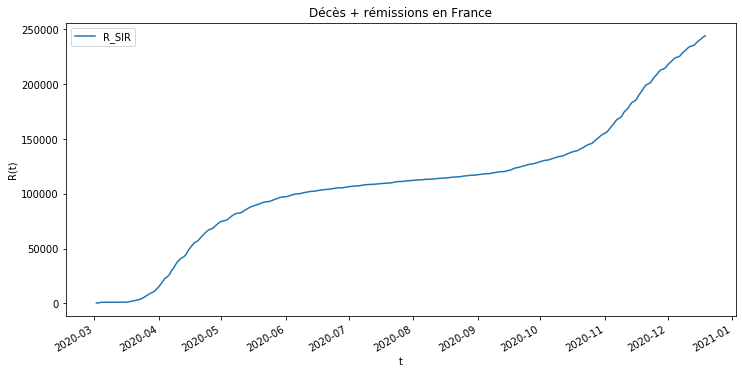

In [59]:
### Tracé de R (modèle SIR)

data_fra["R_SIR"].plot(figsize=(12,6))
plt.title("Décès + rémissions en France")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

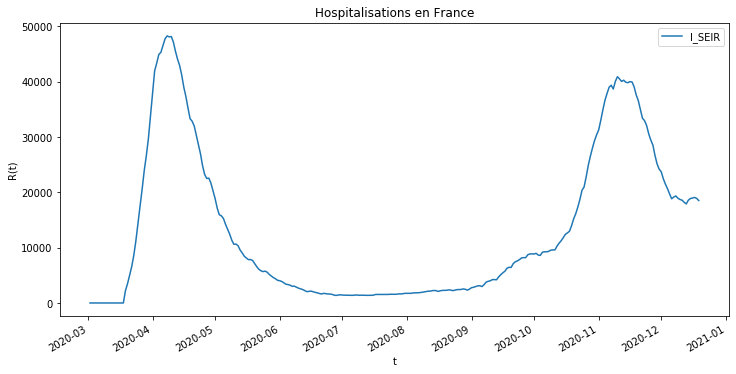

In [60]:
### Tracé de I (modèle SEIR)

data_fra["I_SEIR"].plot(figsize=(12,6))
plt.title("Hospitalisations en France")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

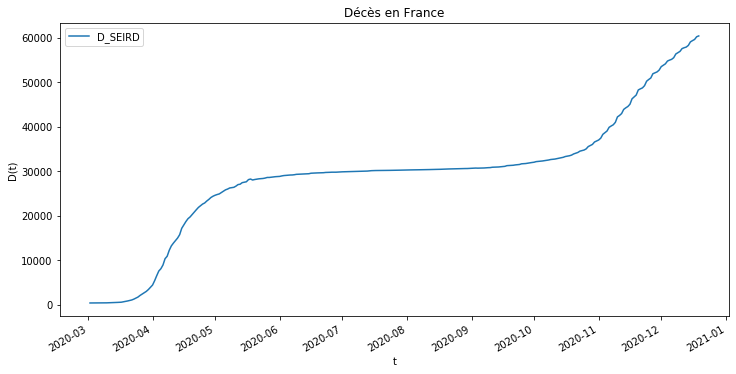

In [61]:
### Tracé de D (modèle SEIRD)

data_fra["D_SEIRD"].plot(figsize=(12,6))
plt.title("Décès en France")
plt.xlabel("t")
plt.ylabel("D(t)")
plt.legend()

plt.show()

#### Séparation des vagues ####

In [62]:
data_fra_v1 = data_fra["2020-03-01":"2020-06-01"]
data_fra_v2 = data_fra["2020-08-01":"2021-01-01"]

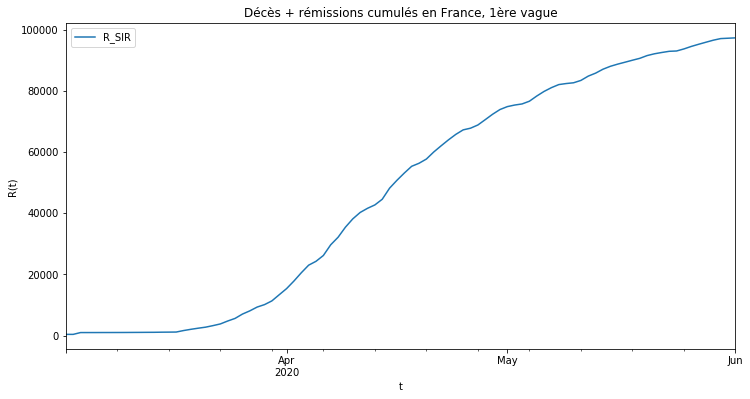

In [63]:
data_fra_v1["R_SIR"].plot(figsize=(12,6))
plt.title("Décès + rémissions cumulés en France, 1ère vague")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

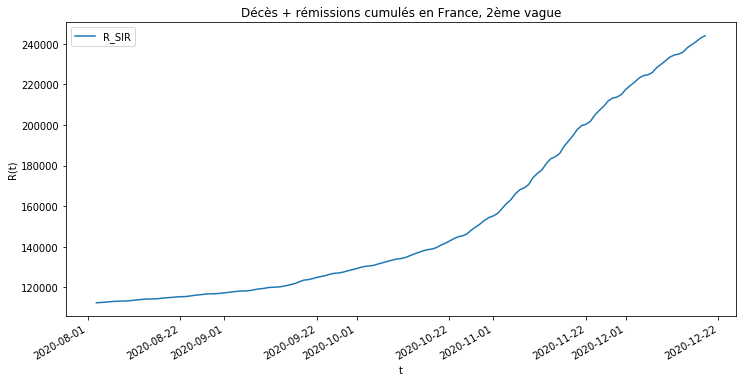

In [64]:
data_fra_v2["R_SIR"].plot(figsize=(12,6))
plt.title("Décès + rémissions cumulés en France, 2ème vague")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.legend()

plt.show()

### 3.2) Données internationales ###

#### Exploration des données ####

In [65]:
### Récupération des données

data_int = pd.read_csv("data-inter.csv")

In [66]:
data_int.head()

,dateRep,year_week,cases_weekly,deaths_weekly,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,notification_rate_per_100000_population_14-days
0,14/12/2020,2020-50,1757,71,Afghanistan,AF,AFG,38041757.0,Asia,9.01
1,07/12/2020,2020-49,1672,137,Afghanistan,AF,AFG,38041757.0,Asia,7.22
2,30/11/2020,2020-48,1073,68,Afghanistan,AF,AFG,38041757.0,Asia,6.42
3,23/11/2020,2020-47,1368,69,Afghanistan,AF,AFG,38041757.0,Asia,6.66
4,16/11/2020,2020-46,1164,61,Afghanistan,AF,AFG,38041757.0,Asia,4.65


In [67]:
data_int.columns

Index(['dateRep', 'year_week', 'cases_weekly', 'deaths_weekly',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'notification_rate_per_100000_population_14-days'],
      dtype='object')

In [68]:
data_int.describe()

,cases_weekly,deaths_weekly,popData2019,notification_rate_per_100000_population_14-days
count,8.938000e+03,8938.000000,8.920000e+03,8708.000000
mean,8.005596e+03,180.540501,4.083927e+07,66.424110
std,4.647885e+04,843.452416,1.525037e+08,163.859423
min,-3.864000e+03,-875.000000,8.150000e+02,-132.600000
25%,6.000000e+00,0.000000,1.293120e+06,0.687500
50%,1.440000e+02,2.000000,7.169456e+06,6.530000
75%,1.982750e+03,31.000000,2.851583e+07,51.427500
max,1.499756e+06,18574.000000,1.433784e+09,1900.840000


In [69]:
data_int.shape

(8938, 10)

#### Gestion des outliers ####

In [70]:
data_int[(data_int["cases_weekly"] < 0) | (data_int["deaths_weekly"] < 0)]

,dateRep,year_week,cases_weekly,deaths_weekly,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,notification_rate_per_100000_population_14-days
913,25/05/2020,2020-21,-148,1,Benin,BJ,BEN,11801151.0,Africa,-1.08
2441,07/09/2020,2020-36,-3864,3969,Ecuador,EC,ECU,17373657.0,America,11.60
4354,14/09/2020,2020-37,-4,0,Jersey,JE,JEY,107796.0,Europe,5.57
4400,27/07/2020,2020-30,-50,0,Jordan,JO,JOR,10101697.0,Asia,-0.11
4606,24/08/2020,2020-34,1135,-439,Kyrgyzstan,KG,KGZ,6415851.0,Asia,45.96
4938,04/05/2020,2020-18,-28,5,Lithuania,LT,LTU,2794184.0,Europe,3.01
4971,31/08/2020,2020-35,-1079,0,Luxembourg,LU,LUX,613894.0,Europe,-132.60
7641,25/05/2020,2020-21,3794,-875,Spain,ES,ESP,46937060.0,Europe,16.26
8329,25/05/2020,2020-21,-15,0,Uganda,UG,UGA,44269587.0,Africa,0.21


In [71]:
### J'ai considéré que ces valeurs erronées ont juste été rentrées avec un signe '-' en trop

data_int["cases_weekly"] = data_int["cases_weekly"].abs()
data_int["deaths_weekly"] = data_int["deaths_weekly"].abs()

#### Mise en forme des données ####

In [72]:
# Regroupement par date et tri
data_int["date"] = pd.to_datetime(data_int['dateRep'], format="%d/%m/%Y")
data_int = data_int.groupby(['date']).sum()
data_int = data_int.drop(["popData2019", "notification_rate_per_100000_population_14-days"], axis=1)
data_int = data_int.sort_index(axis = 0, ascending = True)

# Calcul des valeurs d'intérêt
data_int["D_SEIRD"] = data_int["deaths_weekly"].cumsum()
data_int["I_SEIR"] = data_int["cases_weekly"].rolling(min_periods=1, window=2).sum()

data_int = data_int.drop(["cases_weekly", "deaths_weekly"], axis=1)

In [73]:
data_int.head()

,D_SEIRD,I_SEIR
date,,
2020-01-06,0,59.0
2020-01-13,1,60.0
2020-01-20,3,181.0
2020-01-27,81,2761.0
2020-02-03,362,17133.0


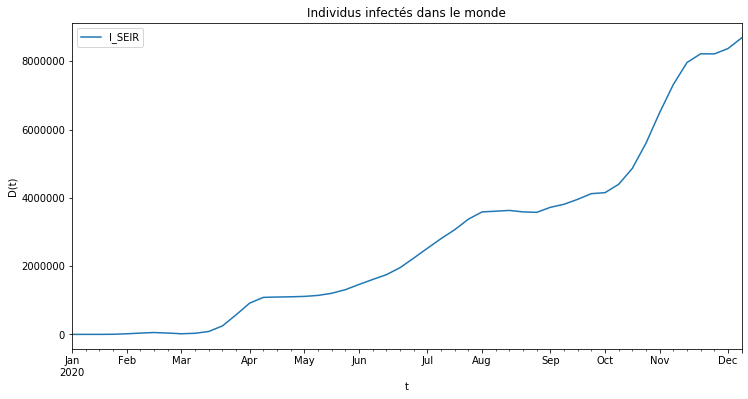

In [74]:
### Tracé de I (modèle SEIR)

data_int["I_SEIR"].plot(figsize=(12,6))

plt.title("Individus infectés dans le monde")
plt.xlabel("t")
plt.ylabel("D(t)")
plt.legend()

plt.show()

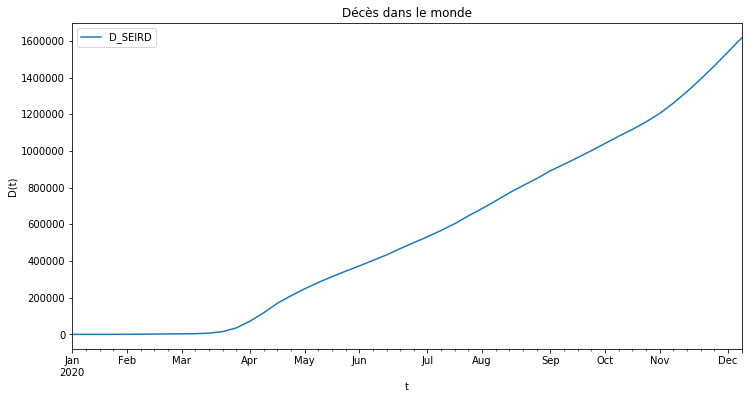

In [75]:
### Tracé de D (modèle SEIRD)

data_int["D_SEIRD"].plot(figsize=(12,6))
plt.title("Décès dans le monde")
plt.xlabel("t")
plt.ylabel("D(t)")
plt.legend()

plt.show()

# <a id="fourth"></a> 4. Identification des paramètres #

### 4.1) Moindres carrés non linéaires ###

#### Approximation de la jacobienne ####

In [76]:
### Approximation de la jacobienne

def jac(f, x, h=10**-5):
    
    # Dimensions (f : R^p -> R^n)
    n = np.size(f(x))
    p = np.size(x)
    
    # Initialisation
    J = np.zeros((n, p))
    
    # Remplissage
    for i in range(p):
        J[:, i] = 1/h*(f(x + h*np.eye(p)[i]) - f(x))
            
    return(J)

#### Algorithme de Gauss-Newton ####

In [77]:
### Méthode de Gauss-Newton

def Gauss_Newton(f, x0, n_iter):
    
    # Initialisation
    k = 0
    x = x0
    
    # Itérations
    for k in range(n_iter):
        A = np.dot(jac(f, x).T, jac(f, x))
        B = np.dot(jac(f, x).T, f(x))
        x = x - np.dot(np.linalg.inv(A), B)

    return(x)

#### Test avec le modèle SIR pour l'épidémie de peste de Bombay ####

In [78]:
### Données en jours

print(data1)

[[    0     0]
 [    7     9]
 [   14    21]
 [   21    35]
 [   28    54]
 [   35    82]
 [   42   138]
 [   49   198]
 [   56   307]
 [   63   452]
 [   70   662]
 [   77   991]
 [   84  1447]
 [   91  1967]
 [   98  2724]
 [  105  3641]
 [  112  4467]
 [  119  5284]
 [  126  6308]
 [  133  7396]
 [  140  8340]
 [  147  9020]
 [  154  9495]
 [  161  9843]
 [  168 10034]
 [  175 10158]
 [  182 10234]
 [  189 10288]
 [  196 10329]
 [  203 10361]
 [  210 10394]]


In [79]:
### Paramètres

n = 2000
T = 220
P = 16961
I0 = 1
R0 = 0

In [80]:
### Modèle utilisé

modele = modele_SIR_R

In [81]:
### Fonction d'interpolation

from scipy.interpolate import interp1d

In [82]:
### Fonction dont la norme est à optimiser

def F_Bombay(x):
    
    n = 2000
    T = 220
    P = 16961
    I0 = 1
    R0 = 0
    
    # x = [gamma, beta]
    p = [P, x[0], x[1], I0, R0]
    t_RK4, R_RK4 = RK4(modele, 0, T, R0, n, p)
    
    # Interpolation des valeurs estimées
    fR = interp1d(t_RK4, R_RK4)
    
    # Construction de la fonction comparant données et modèle
    F = np.hstack([fR(data1[:, 0]) - data1[:, 1] ])
        
    return(F)

In [83]:
### Optimisation par la méthode de Gauss-Newton

# Initialisation x0 = [gamma0, beta0]
x0 = np.array([0.3, 0.5])

# Optimisation
gamma_sim, beta_sim = Gauss_Newton(F_Bombay, x0, n_iter=10)

gamma estimé =  0.1393
beta estimé =  0.2157


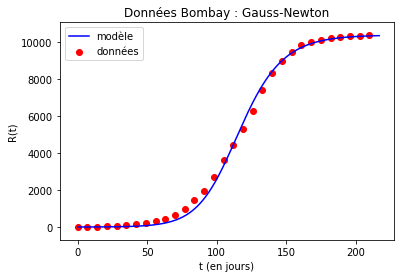

In [84]:
### Visualisation des paramètres optimaux

p = [P, gamma_sim, beta_sim, I0, R0]
modele = modele_SIR_R
schema = RK4(modele, 0, len(data)*7, R0, n, p)

plt.plot(schema[0], schema[1], c="blue", label="modèle")
plt.scatter(data1[:,0], data1[:,1], c="red", label="données")
plt.title("Données Bombay : Gauss-Newton")
plt.xlabel("t (en jours)")
plt.ylabel("R(t)")
plt.legend()

print("gamma estimé = ", round(gamma_sim, 4))
print("beta estimé = ", round(beta_sim, 4))

### 4.2) Aller plus loin ###

#### a) Recherche linéaire et méthode de Levenberg-Marquardt ####

In [85]:
### Données Bombay

n = 2000
T = 220
P = 16961
I0 = 1
R0 = 0

modele = modele_SIR_R

#### Recherche linéaire ####

In [86]:
### Recherche linéaire 

def recherche_lin(f, x0, n_iter):
    
    k = 0
    x = x0
    
    for k in range(n_iter):

        A = np.dot(jac(f, x).T, jac(f, x))
        B = np.dot(jac(f, x).T, f(x))
        d = - np.dot(np.linalg.inv(A), B)
        
        rho = 1
        
        while(np.linalg.norm(f(x+rho*d)) > np.linalg.norm(f(x))):
            rho /= 10
            
        x = x + rho*d

    return(x)

In [87]:
### Optimisation par la méthode de recherche linéaire

x0 = np.array([0.2, 0.3])
gamma_sim, beta_sim = recherche_lin(F_Bombay, x0, n_iter=5)

gamma estimé =  0.1392
beta estimé =  0.2157


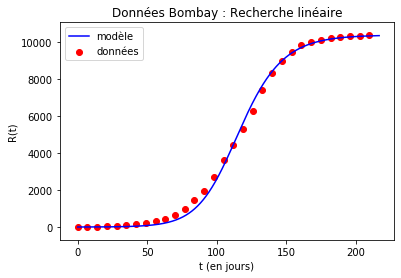

In [88]:
### Visualisation des paramètres optimaux

p = [P, gamma_sim, beta_sim, I0, R0]
modele = modele_SIR_R
schema = RK4(modele, 0, len(data)*7, R0, n, p)

plt.plot(schema[0], schema[1], c="blue", label="modèle")
plt.scatter(data1[:,0], data1[:,1], c="red", label="données")
plt.title("Données Bombay : Recherche linéaire")
plt.xlabel("t (en jours)")
plt.ylabel("R(t)")
plt.legend()

print("gamma estimé = ", round(gamma_sim, 4))
print("beta estimé = ", round(beta_sim, 4))

#### Levenberg-Marquardt ####

In [89]:
### Levenberg-Marquardt

def Lev_Mar(f, x0, n_iter, lbd=10**-1):
    
    k = 0
    x = x0
    
    for k in range(n_iter):

        A = np.dot(jac(f, x).T, jac(f, x)) + lbd*np.eye(np.size(x))
        B = np.dot(jac(f, x).T, f(x))
        d = - np.dot(np.linalg.inv(A), B)
        
        rho = 1

        while(np.linalg.norm(f(x+rho*d)) > np.linalg.norm(f(x))):
            rho /= 10
            
        x = x + rho*d

    return(x)

In [90]:
### Optimisation par la méthode de Levenberg-Marquardt

x0 = np.array([0.2, 0.3])
gamma_sim, beta_sim = Lev_Mar(F_Bombay, x0, n_iter=5, lbd=10**-1)

gamma estimé =  0.1392
beta estimé =  0.2157


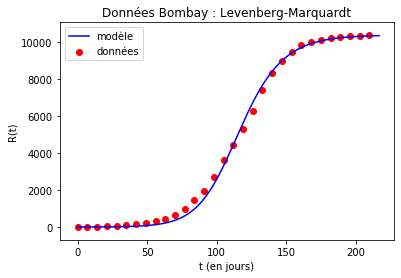

In [91]:
### Visualisation des paramètres optimaux

p = [P, gamma_sim, beta_sim, I0, R0]
modele = modele_SIR_R
schema = RK4(modele, 0, len(data)*7, R0, n, p)

plt.plot(schema[0], schema[1], c="blue", label="modèle")
plt.scatter(data1[:,0], data1[:,1], c="red", label="données")
plt.title("Données Bombay : Levenberg-Marquardt")
plt.xlabel("t (en jours)")
plt.ylabel("R(t)")
plt.legend()

print("gamma estimé = ", round(gamma_sim, 4))
print("beta estimé = ", round(beta_sim, 4))

#### b) Identification des paramètres du modèle SIR pour la 1ère vague en France ####

In [92]:
data_fra_v1.head()

,R_SIR,I_SEIR,D_SEIRD,jour
date,,,,
2020-03-02,386.0,0.0,374.0,47
2020-03-03,387.0,0.0,375.0,48
2020-03-04,977.0,0.0,375.0,49
2020-03-05,980.0,0.0,378.0,50
2020-03-06,982.0,0.0,380.0,51


In [93]:
### Paramètres

n = 2000
T = 200
P = 120000
I0 = 1
R0 = 0

In [94]:
### Modèle utilisé

modele = modele_SIR_R

In [95]:
def F_fra_SIR_v1(x):
    
    # x = [gamma, beta]
    p = [P, x[0], x[1], I0, R0]
    t_RK4, R_RK4 = RK4(modele, 0, T, R0, n, p)
    
    # Interpolation des valeurs estimées
    fR = interp1d(t_RK4, R_RK4)
    
    # Construction de la fonction comparant données et modèle
    F = np.hstack([fR(data_fra_v1["jour"]) - data_fra_v1["R_SIR"] ])
    
    return(F)

In [96]:
# Initialisation x0 = [gamma0, beta0]
x0 = np.array([0.2, 0.3])

# Optimisation
gamma_sim, beta_sim = Lev_Mar(F_fra_SIR_v1, x0, n_iter=10)

gamma estimé =  0.1292
beta estimé =  0.2591


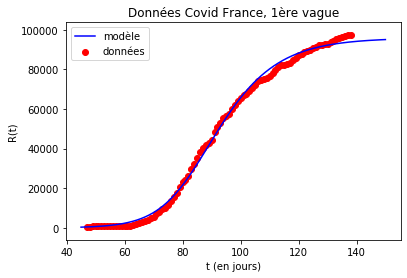

In [97]:
### Visualisation des paramètres optimaux

p = [P, gamma_sim, beta_sim, I0, R0]
modele = modele_SIR_R
schema = RK4(modele, 0, T, R0, n, p)

plt.plot(schema[0][450:1500], schema[1][450:1500], c="blue", label="modèle")
plt.scatter(data_fra_v1["jour"], data_fra_v1["R_SIR"], c="red", label="données")
plt.title("Données Covid France, 1ère vague")
plt.xlabel("t (en jours)")
plt.ylabel("R(t)")
plt.legend()

print("gamma estimé = ", round(gamma_sim, 4))
print("beta estimé = ", round(beta_sim, 4))